数据集：BikeShares.csv

感谢网易云课堂：唐国梁Tommy

## 实现流程
1. 加载数据集、数据可视化、预处理
2. 特征工程
3. 构建模型
4. 模型编译、训练、验证

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras import Sequential, layers, utils, losses
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [2]:
import warnings
warnings.filterwarnings('ignore')

第1步：加载数据集、预处理

In [3]:
# 加载数据集
dataset = pd.read_csv("BikeShares.csv", parse_dates=["timestamp"], index_col=["timestamp"])

In [6]:
dataset.shape

(17414, 9)

In [9]:
# 默认显示前5行
dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [10]:
# 默认显示后5行
dataset.tail()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0
2017-01-03 23:00:00,139,5.0,1.0,76.0,22.0,2.0,0.0,0.0,3.0


#### 字段说明：

* timestamp : 时间戳
* cnt : 租用共享单车的数量（目标值）
* t1 : 气温
* t2 : 体感温度
* hum : 湿度
* wind_speed : 风速
* weather_code : 天气的类别（1=干净，2 =很少的云，3=碎云，4=多云，7=雨/小雨，10=有雷雨，26=降雪，94=冰雾）
* is_holiday : 是否为假期（1:假期 / 0:工作日）
* is_weekend : 是否为周末（1:周末 / 0：工作日）
* season : 季节（0:春天 ; 1:夏天 ; 2:秋天 ; 3:冬天）

In [13]:
# 数据集信息
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


In [14]:
# 数据集描述
dataset.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


第2步：数据集可视化

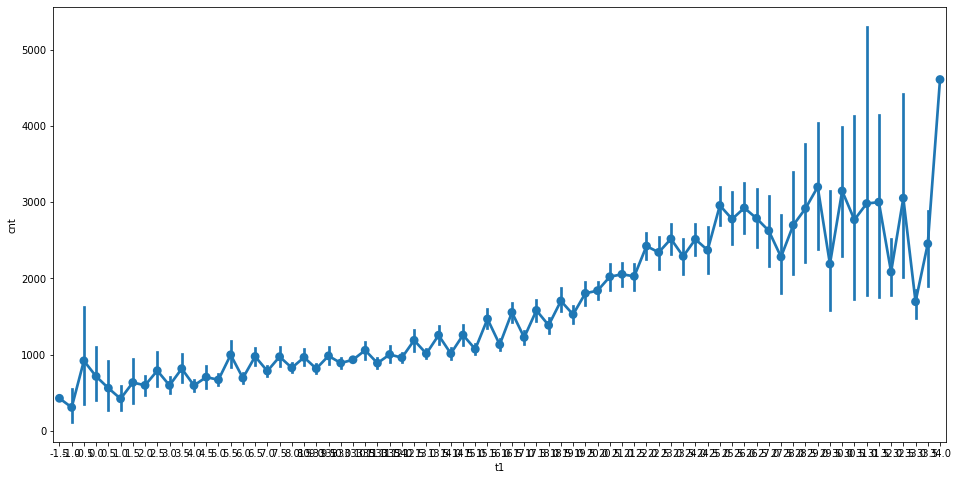

In [15]:
# 显示t1(气温)与字段cnt(单车使用量)之间的关系
plt.figure(figsize=(16, 8))
sns.pointplot(x="t1", y="cnt", data=dataset)
plt.show()

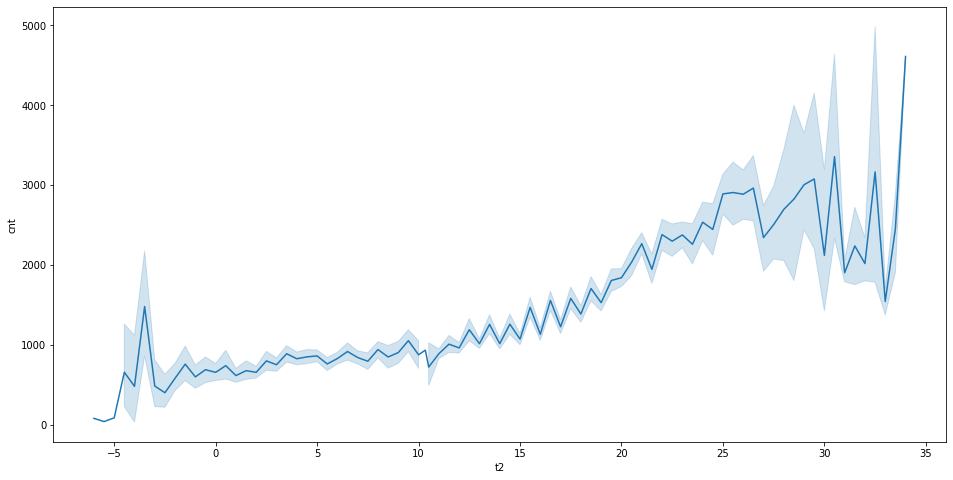

In [18]:
# 显示t2(体感温度)与字段cnt(单车使用量)之间的关系
plt.figure(figsize=(16, 8))
sns.lineplot(x="t2", y="cnt", data=dataset)
plt.show()

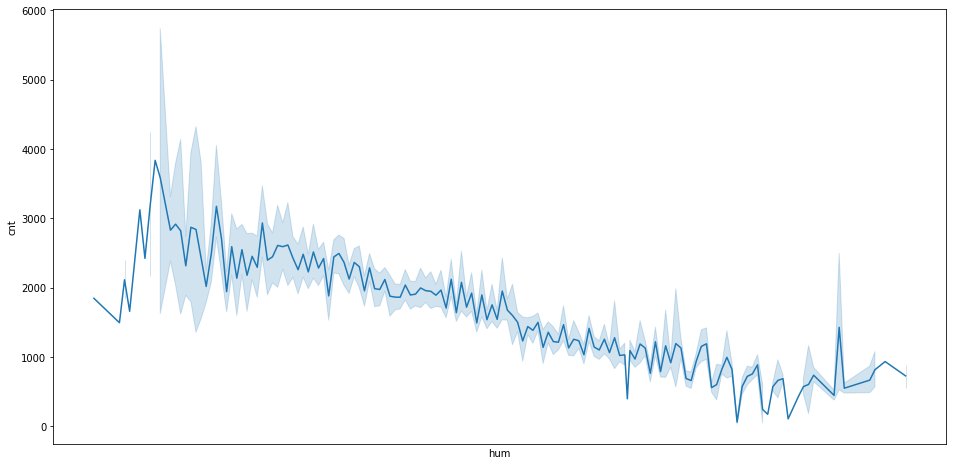

In [20]:
# 显示hum(湿度)与字段cnt(单车使用量)之间的关系
plt.figure(figsize=(16, 8))
sns.lineplot(x="hum", y="cnt", data=dataset)
plt.xticks([])
plt.show()

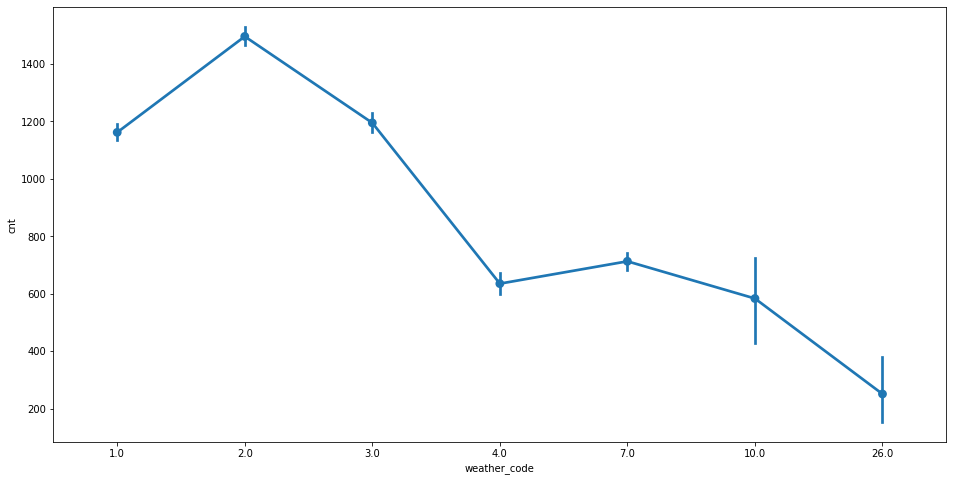

In [21]:
# 字段weather_code : 天气的类别与字段cnt(单车使用量)之间的关系
# weather_code : 天气的类别（1=干净，2 =很少的云，3=碎云，4=多云，7=雨/小雨，10=有雷雨，26=降雪，94=冰雾

plt.figure(figsize=(16,8))
sns.pointplot(x='weather_code', y='cnt', data=dataset)
plt.show()

注意：创建时间字段，用于分析数据

In [31]:
# 创建hour字段
dataset["hour"] = dataset.index.hour

In [34]:
# 创建year字段
dataset["year"] = dataset.index.year

In [32]:
# 创建month字段
dataset["month"] = dataset.index.month

In [35]:
dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month,year
timestamp,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,1,2015
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,1,2015
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,1,2015
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,1,2015
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,1,2015


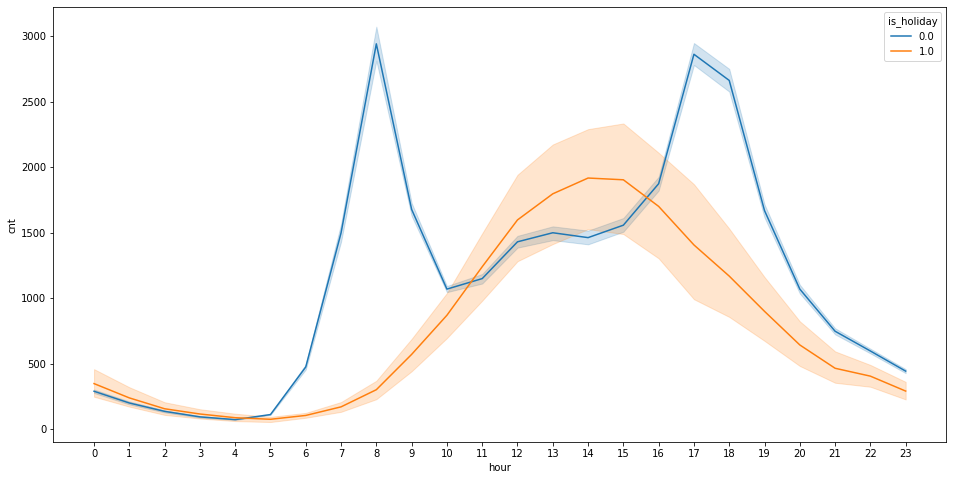

In [37]:
# 基于is_holiday 统计 hour 与 cnt 之间的分布
# 1:假期 / 0:工作日
plt.figure(figsize=(16,8))
sns.lineplot(x="hour", y="cnt", data=dataset, hue="is_holiday")
plt.xticks(list(range(24)))
plt.show()

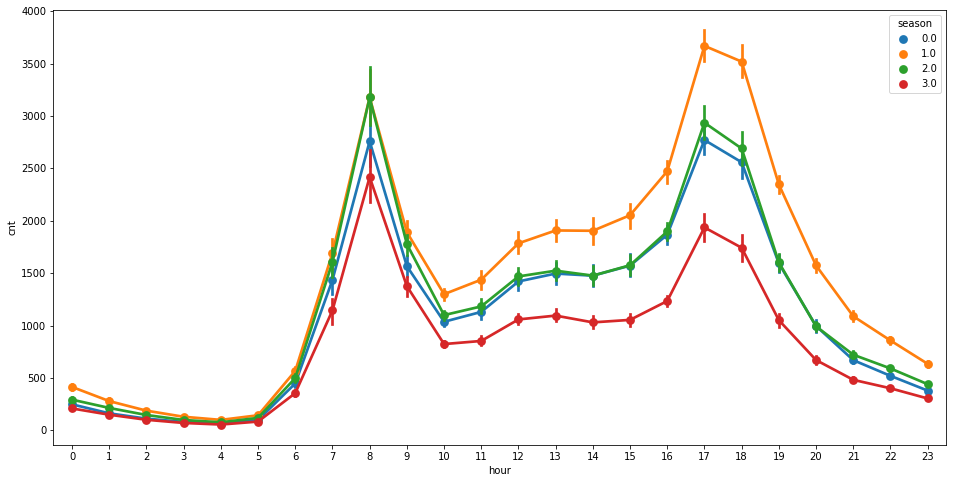

In [38]:
# 基于 season 统计 hour 与 cnt 之间的分布
# 0:春天 ; 1:夏天 ; 2:秋天 ; 3:冬天
plt.figure(figsize=(16,8))
sns.pointplot(x="hour", y="cnt", data=dataset, hue="season")
plt.xticks(list(range(24)))
plt.show()

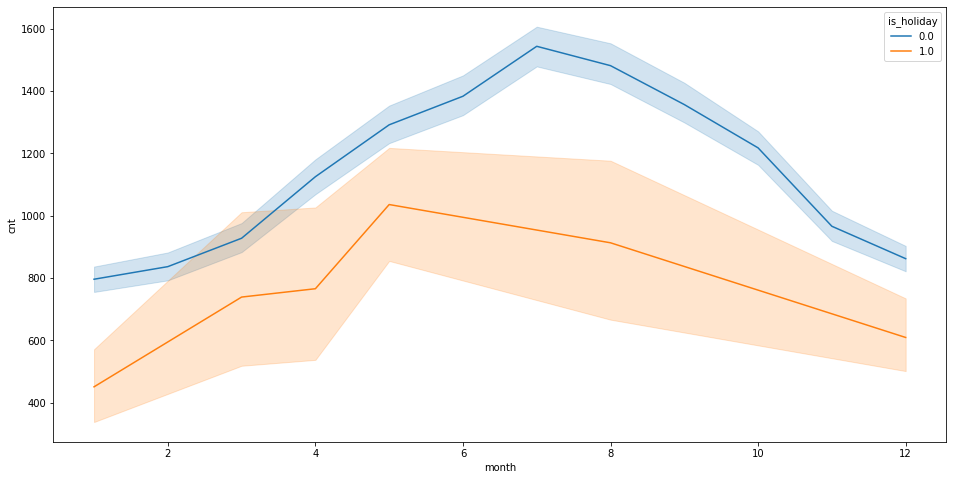

In [41]:
# 基于 is_holiday 统计 hour 与 cnt 之间的分布
# 1:假期 / 0:工作日
plt.figure(figsize=(16,8))
sns.lineplot(x='month', y='cnt', data=dataset, hue='is_holiday')
# plt.xticks(list(range(24)))
plt.show()

第3步：数据预处理

In [42]:
dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month,year
timestamp,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,1,2015
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,1,2015
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,1,2015
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,1,2015
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,1,2015


In [43]:
# 删除多余的列
dataset.drop(columns=["hour", "year", "month"], axis=1, inplace=True)

In [46]:
dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


* 注意事项：
* 1. cnt : 是标签；
* 2. t1, t2, hum, wind_speed : 是数值类型字段；
* 3. weather_code, is_holiday, is_weekend, season : 是分类类型字段；

In [47]:
# 分别对字段t1, t2, hum, wind_speed进行归一化
columns = ['cnt', 't1', 't2', 'hum', 'wind_speed']
for col in columns:
  scaler = MinMaxScaler()
  dataset[col] = scaler.fit_transform(dataset[col].values.reshape(-1,1))
dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,0.023155,0.126761,0.2000,0.911950,0.106195,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,0.017557,0.126761,0.2125,0.911950,0.088496,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,0.017048,0.112676,0.2125,0.955975,0.000000,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,0.009160,0.098592,0.2000,1.000000,0.000000,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,0.005980,0.098592,0.1500,0.911950,0.115044,1.0,0.0,1.0,3.0


第4步：特征工程

In [48]:
# 特征数据集
X = dataset.drop(columns=["cnt"], axis=1)
# 标签数据集
y = dataset["cnt"]

In [49]:
X.shape

(17414, 8)

In [50]:
y.shape

(17414,)

In [51]:
# 1 数据集分离： X_train, X_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=666)

In [52]:
X_train.head()

,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,
2015-01-04 00:00:00,0.126761,0.2000,0.911950,0.106195,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,0.126761,0.2125,0.911950,0.088496,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,0.112676,0.2125,0.955975,0.000000,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,0.098592,0.2000,1.000000,0.000000,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,0.098592,0.1500,0.911950,0.115044,1.0,0.0,1.0,3.0


In [53]:
X_test.head()

,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,
2016-08-10 03:00:00,0.408451,0.4750,0.710692,0.283186,1.0,0.0,0.0,1.0
2016-08-10 04:00:00,0.408451,0.4750,0.710692,0.247788,1.0,0.0,0.0,1.0
2016-08-10 05:00:00,0.394366,0.4625,0.742138,0.230088,1.0,0.0,0.0,1.0
2016-08-10 06:00:00,0.408451,0.4750,0.742138,0.265487,1.0,0.0,0.0,1.0
2016-08-10 07:00:00,0.422535,0.4875,0.679245,0.283186,2.0,0.0,0.0,1.0


In [54]:
# 2 构造特征数据集
def create_dataset(X, y, seq_len=10):
    features = []
    targets = []
    
    for i in range(0, len(X) - seq_len, 1):
        data = X.iloc[i:i+seq_len] # 序列数据
        label = y.iloc[i+seq_len] # 标签数据
        # 保存到features和labels
        features.append(data)
        targets.append(label)
    
    # 返回
    return np.array(features), np.array(targets)

In [55]:
# ① 构造训练特征数据集
train_dataset, train_labels = create_dataset(X_train, y_train, seq_len=10)

In [58]:
train_dataset

array([[[0.12676056, 0.2       , 0.91194969, ..., 0.        ,
         1.        , 3.        ],
        [0.12676056, 0.2125    , 0.91194969, ..., 0.        ,
         1.        , 3.        ],
        [0.11267606, 0.2125    , 0.95597484, ..., 0.        ,
         1.        , 3.        ],
        ...,
        [0.07042254, 0.125     , 1.        , ..., 0.        ,
         1.        , 3.        ],
        [0.08450704, 0.125     , 0.95597484, ..., 0.        ,
         1.        , 3.        ],
        [0.09859155, 0.1375    , 1.        , ..., 0.        ,
         1.        , 3.        ]],

       [[0.12676056, 0.2125    , 0.91194969, ..., 0.        ,
         1.        , 3.        ],
        [0.11267606, 0.2125    , 0.95597484, ..., 0.        ,
         1.        , 3.        ],
        [0.09859155, 0.2       , 1.        , ..., 0.        ,
         1.        , 3.        ],
        ...,
        [0.08450704, 0.125     , 0.95597484, ..., 0.        ,
         1.        , 3.        ],
        [0.0

In [59]:
# ② 构造测试特征数据集
test_dataset, test_labels = create_dataset(X_test, y_test, seq_len=10)

In [61]:
# 3 构造批数据
def create_batch_dataset(X, y, train=True, buffer_size=1000, batch_size=128):
    batch_data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # 数据封装，tensor类型
    if train:  # 训练集
        return batch_data.cache().shuffle(buffer_size).batch(batch_size)
    else:    # 测试集
        return batch_data.batch(batch_size)

In [62]:
# 训练批数据
train_batch_dataset = create_batch_dataset(train_dataset, train_labels)

In [63]:
# 测试批数据
test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)

In [64]:
train_batch_dataset

<BatchDataset shapes: ((None, 10, 8), (None,)), types: (tf.float64, tf.float64)>

In [65]:
# 从测试批数据中，获取一个batch_size的样本数据
list(test_batch_dataset.as_numpy_iterator())[0]

(array([[[0.4084507 , 0.475     , 0.71069182, ..., 0.        ,
          0.        , 1.        ],
         [0.4084507 , 0.475     , 0.71069182, ..., 0.        ,
          0.        , 1.        ],
         [0.3943662 , 0.4625    , 0.74213836, ..., 0.        ,
          0.        , 1.        ],
         ...,
         [0.50704225, 0.5625    , 0.50943396, ..., 0.        ,
          0.        , 1.        ],
         [0.52112676, 0.575     , 0.39622642, ..., 0.        ,
          0.        , 1.        ],
         [0.52112676, 0.575     , 0.39622642, ..., 0.        ,
          0.        , 1.        ]],
 
        [[0.4084507 , 0.475     , 0.71069182, ..., 0.        ,
          0.        , 1.        ],
         [0.3943662 , 0.4625    , 0.74213836, ..., 0.        ,
          0.        , 1.        ],
         [0.4084507 , 0.475     , 0.74213836, ..., 0.        ,
          0.        , 1.        ],
         ...,
         [0.52112676, 0.575     , 0.39622642, ..., 0.        ,
          0.        , 1.

第5步：模型搭建、编译、训练

In [66]:
# 模型搭建
model = Sequential([
    layers.LSTM(units=256, input_shape=train_dataset.shape[-2:], return_sequences=True),
    layers.Dropout(0.4),
    layers.LSTM(units=256, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(units=128, return_sequences=True),
    layers.LSTM(units=32),
    layers.Dense(1)
])

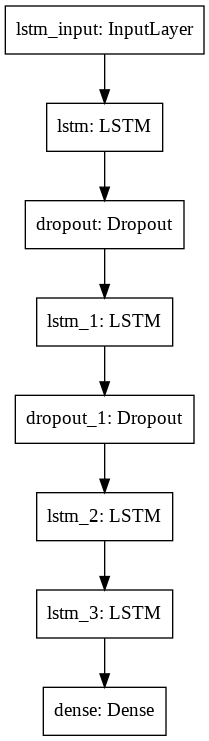

In [67]:
# 显示模型结构
utils.plot_model(model)

In [68]:
# 模型编译
model.compile(optimizer="adam", loss="mse")

In [69]:
# 保存模型权重文件和训练日志

!rm -rf logs

log_file = os.path.join('logs', datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

tensorboard_callback = TensorBoard(log_file)

In [70]:
checkpoint_file = "best_model.hdf5"

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_file, 
                    monitor='loss',
                    mode='min',
                    save_best_only=True,
                    save_weights_only=True)

In [71]:
# 模型训练
history = model.fit(train_batch_dataset,
          epochs=30,
          validation_data=test_batch_dataset,
          callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/30
109/109 [==============================] - 37s 279ms/step - loss: 0.0224 - val_loss: 0.0195
Epoch 2/30
109/109 [==============================] - 28s 261ms/step - loss: 0.0162 - val_loss: 0.0197
Epoch 3/30
109/109 [==============================] - 29s 262ms/step - loss: 0.0134 - val_loss: 0.0161
Epoch 4/30
109/109 [==============================] - 29s 263ms/step - loss: 0.0127 - val_loss: 0.0137
Epoch 5/30
109/109 [==============================] - 28s 261ms/step - loss: 0.0120 - val_loss: 0.0144
Epoch 6/30
109/109 [==============================] - 28s 260ms/step - loss: 0.0116 - val_loss: 0.0145
Epoch 7/30
109/109 [==============================] - 28s 261ms/step - loss: 0.0116 - val_loss: 0.0143
Epoch 8/30
109/109 [==============================] - 28s 261ms/step - loss: 0.0110 - val_loss: 0.0149
Epoch 9/30
109/109 [==============================] - 28s 260ms/step - loss: 0.0112 - val_loss: 0.0125
Epoch 10/30
109/109 [==============================] - 28s 260ms/step - l

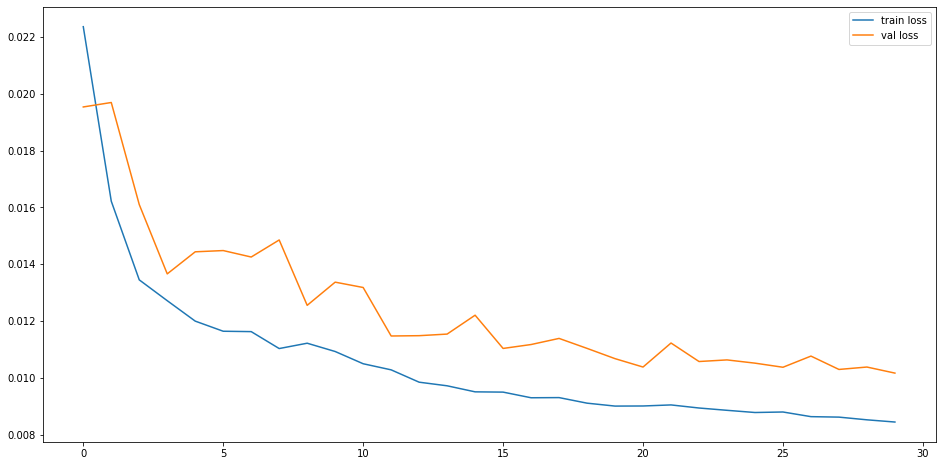

In [72]:
# 显示训练结果

plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()